In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from jiwer import wer
from IPython import display
from datetime import datetime

now = datetime.now()
dt = now.strftime("%Y%m%d.%H%M%S")
print (dt)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

2022-09-21 13:47:44.394956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 13:47:44.572123: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-21 13:47:44.634345: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-21 13:47:45.610556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

20220921.134747


In [2]:
#data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
#data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
#wavs_path = data_path + "/wavs/"
#metadata_path = data_path + "/metadata.csv"
wavs_path = "dataset/clovacall/wavs_train/"
metadata_path = "dataset/clovacall/metadata.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,43_0524_500_1_05682_03,아웃백 할인카드가 있나요?
1,43_0604_500_0_06814_05,제휴할인 카드 뭐뭐 있나요?
2,42_0527_606_0_01588_00,휴무일이 언제인가요?


In [3]:
split = int(len(metadata_df) * 0.90)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the training set: {len(df_val)}")

Size of the training set: 53695
Size of the training set: 5967


In [4]:
token_map = {}
tokens = ""

for sentence in metadata_df.normalized_transcription:
    for syllable in list(sentence):
        if not syllable in token_map:
            token_map[syllable] = 1

for token in token_map:
    tokens = tokens + token

print (tokens)

아웃백 할인카드가있나요?제휴뭐무일이언침시간에도영업하기먹을수는메뉴몇까지여방배동예.달주문능한오픈과마감어떻게되발레파킹서비스렛금은얼그럼,토호트테크부탁립니다점심으려고데약받투움바타갈릭해세단체런임출건야돼률높평중복번4명차공멤버십추석연안쉬날없치터신대혹면내죠녕포장했로변경늘말들따설식사음않결때벤같킨텐더샐러랑홈프화전1성남녀0자리특별닫용구네후3쯤겠습진두우막좋통많떤혜택량찹박콜라저녁곳를것9좀작르분운잡실생앉와함께7당합티룸민입미찾정될옆갔브져~꺼괜찮skt골각엇원알강역길빌딩선물상품권쓰적새콤족모거창2싶늦느폭큰lg유플개월김슬층끝취학린궁껀끌못련피닉만확뜰폰락5키즈쉽%꼭매잘즘6조행뒤의종류섯쪽울희반잔머천애손님소셋블뭔료8편히율퍼센디최홍계산팀회랴빛-벽씹쓸젠열멀맞처던똑온람꿔쿠표른긴봉위케익준앞견빼효절낮직접넓됩캘렸보넵광근캐즌페셜릴노셔관빨렇래걸흠냥현베튀멜팅놓철엔졸줘몬딜루삼잠둘태증/판갑!워착군랙벨패밀논렴맛채밤았줄끼놔총었뀌초깐협살짝콕였슨탐올빵쳐랜먼큐촌재년뷰맡돈송된냉북덕짜춰록극죄짐붐등겸불휠깥망너겼랍텔링엘켜누vip황양뜻필딱붙떡친헤묶혼넉맨코본돌셧숭교났목웰꿀쥬핸땅널겨렬쭉끄럽찬툰악밥질od충항잇팔u풍림찍윈속켰승왔환춘넛담급씀a또싸탄릉며칠콘름첫>볼집맵병앱듬형랫범액갖벼법됐외렌콩뇨핑볶칸혀좁커죽닙갠술굽허쨈든쁜욜쭤봐글축겁독램넘？웨웠찼덟n뮤팥픽닌엽규럴잖얄빅국깔끔념곱둬뗗뽑뭘션눕봄욕략빙육홀곡칼킬청꽉츠컨째획


In [5]:
# The set of characters accepted in the transcription.


#characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
characters = [x for x in tokens]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

2022-09-21 13:47:47.832858: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-21 13:47:48.980939: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30973 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:00:09.0, compute capability: 7.0


The vocabulary is: ['', '아', '웃', '백', ' ', '할', '인', '카', '드', '가', '있', '나', '요', '?', '제', '휴', '뭐', '무', '일', '이', '언', '침', '시', '간', '에', '도', '영', '업', '하', '기', '먹', '을', '수', '는', '메', '뉴', '몇', '까', '지', '여', '방', '배', '동', '예', '.', '달', '주', '문', '능', '한', '오', '픈', '과', '마', '감', '어', '떻', '게', '되', '발', '레', '파', '킹', '서', '비', '스', '렛', '금', '은', '얼', '그', '럼', ',', '토', '호', '트', '테', '크', '부', '탁', '립', '니', '다', '점', '심', '으', '려', '고', '데', '약', '받', '투', '움', '바', '타', '갈', '릭', '해', '세', '단', '체', '런', '임', '출', '건', '야', '돼', '률', '높', '평', '중', '복', '번', '4', '명', '차', '공', '멤', '버', '십', '추', '석', '연', '안', '쉬', '날', '없', '치', '터', '신', '대', '혹', '면', '내', '죠', '녕', '포', '장', '했', '로', '변', '경', '늘', '말', '들', '따', '설', '식', '사', '음', '않', '결', '때', '벤', '같', '킨', '텐', '더', '샐', '러', '랑', '홈', '프', '화', '전', '1', '성', '남', '녀', '0', '자', '리', '특', '별', '닫', '용', '구', '네', '후', '3', '쯤', '겠', '습', '진', '두', '우', '막', '좋', '통', '많', '떤', '혜', '택', '량', '찹', '박', '

In [6]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

In [7]:
batch_size = 32
# Define the trainig dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["normalized_transcription"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["normalized_transcription"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

/home/hyhwang/repositories/model/caption/tf2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyhwang/repositories/model/caption/tf2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50883 (\N{HANGUL SYLLABLE US}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyhwang/repositories/model/caption/tf2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48177 (\N{HANGUL SYLLABLE BAEG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyhwang/repositories/model/caption/tf2/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54624 (\N{HANGUL SYLLABLE HAL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyhwang/repositories/model/caption/tf2/lib/python3.9/site-packages/IPython/core/pylabtools.py:15

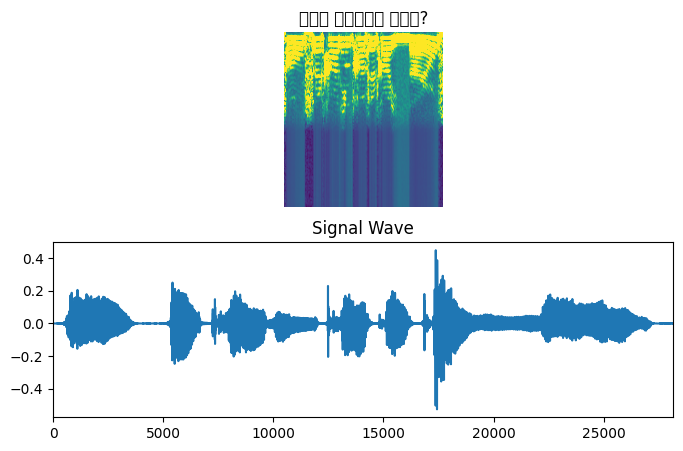

In [8]:
ig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [9]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [10]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model


# Get the model
model = build_model(
    input_dim=fft_length // 2 + 1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "DeepSpeech_2"
______________________________________________________________________________________________________________
 Layer (type)                                    Output Shape                                Param #          
 input (InputLayer)                              [(None, None, 193)]                         0                
                                                                                                              
 expand_dim (Reshape)                            (None, None, 193, 1)                        0                
                                                                                                              
 conv_1 (Conv2D)                                 (None, None, 97, 32)                        14432            
                                                                                                              
 conv_1_bn (BatchNormalization)                  (None, None, 97, 32)                     

In [11]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [12]:
# Define the number of epochs.
epochs = 50
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/50


2022-09-21 13:48:12.289132: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 4s 4s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9983
----------------------------------------------------------------------------------------------------
Target    : 마지막 오더가 몇시인가요?
Prediction: 예있나요?
----------------------------------------------------------------------------------------------------
Target    : 토요일 영업 시간 알려주세요.
Prediction: 주나요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 2655s 2s/step - loss: 85.8524 - val_loss: 75.5944
Epoch 2/50
1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 456ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.9192
----------------------------------------------------------------------------------------------------
Target    : 생일 쿠폰 받았는데 다른 할인과 중복 안되죠?
Prediction: 생  죠?
----------------------------------------------------------------------------------------------------
Target    : 아기가 먹기 좋은 메뉴 추천해주세요.
Prediction: 아  요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1125s 671ms/step - loss: 57.9939 - val_loss: 46.2531
Epoch 3/50
1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 424ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.7968
----------------------------------------------------------------------------------------------------
Target    : 아웃백 영업 안할 때도 있나요?
Prediction: 아 영   있나요?
----------------------------------------------------------------------------------------------------
Target    : 단체 예약할 자리 있나요?
Prediction: 단체예약 자리 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1124s 670ms/step - loss: 38.0196 - val_loss: 29.8084
Epoch 4/50
1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 443ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.6536
----------------------------------------------------------------------------------------------------
Target    : 영업시간 언제부터 시작이에요?
Prediction: 영시간 언제터시작에요?
----------------------------------------------------------------------------------------------------
Target    : 배달 되나요?
Prediction: 배달 되나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 668ms/step - loss: 27.8320 - val_loss: 22.6918
Epoch 5/50
1/1 [==============================] - 0s 218ms/step


1/1 [==============================] - 0s 424ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5601
----------------------------------------------------------------------------------------------------
Target    : 제휴 할인되는 카드가 뭔가요?
Prediction: 제휴 할인되는 카드가 뭔가요?
----------------------------------------------------------------------------------------------------
Target    : 학생할인과 통신사 할인 같이 받을 수 있나요?
Prediction: 학생 할인과 통신사 할인 같이 받을 수 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 21.9798 - val_loss: 19.1996
Epoch 6/50
1/1 [==============================] - 0s 297ms/step


1/1 [==============================] - 0s 427ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.5100
----------------------------------------------------------------------------------------------------
Target    : 영업 안하는 날 있나요?
Prediction: 매을 안는 날 있나요?
----------------------------------------------------------------------------------------------------
Target    : 몇시부터 오픈하나요?
Prediction: 몇시에 오픈하나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 18.4688 - val_loss: 17.2125
Epoch 7/50
1/1 [==============================] - 0s 413ms/step


1/1 [==============================] - 0s 442ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4654
----------------------------------------------------------------------------------------------------
Target    : 런치 메뉴도 미리 주문 가능한가요?
Prediction: 런치메뉴도 미리 주문 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 내일 몇 시에 오픈하시나요?
Prediction: 내 몇시에 오픈하시나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1123s 669ms/step - loss: 15.7722 - val_loss: 15.4087


Epoch 8/50
1/1 [==============================] - 0s 323ms/step


1/1 [==============================] - 0s 425ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4383
----------------------------------------------------------------------------------------------------
Target    : 몇 시에 열어요?
Prediction: 몇시에 열어요?
----------------------------------------------------------------------------------------------------
Target    : 조용한 자리로 예약 가능할까요?
Prediction: 조한 자리로 예약 가능할까요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1170s 698ms/step - loss: 13.8943 - val_loss: 14.1882
Epoch 9/50
1/1 [==============================] - 0s 204ms/step


1/1 [==============================] - 0s 479ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.4065
----------------------------------------------------------------------------------------------------
Target    : 목요일 저녁 6시 예약 다 차있나요?
Prediction: 오요 저녁 6시 예약자 있나요?
----------------------------------------------------------------------------------------------------
Target    : 내일 선거날인데, 정상 오픈이에요?
Prediction: 네 문할인드 선정 이요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1119s 667ms/step - loss: 12.4784 - val_loss: 13.0693
Epoch 10/50
1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 423ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3925
----------------------------------------------------------------------------------------------------
Target    : 주차 가능한가요?
Prediction: 주차 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 오후 7시요.
Prediction: 오후 7시요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 11.3885 - val_loss: 12.4863
Epoch 11/50
1/1 [==============================] - 0s 289ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 431ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3662
----------------------------------------------------------------------------------------------------
Target    : 아웃백에서 메뉴를 추천받고 싶습니다.
Prediction: 아웃백에서 메뉴를 추천 받고싶습니다?
----------------------------------------------------------------------------------------------------
Target    : 맵지 않은 메뉴가 있나요?
Prediction: 맵시 은 메뉴가 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1128s 672ms/step - loss: 10.5430 - val_loss: 11.9317
Epoch 12/50
1/1 [==============================] - 0s 220ms/step


1/1 [==============================] - 0s 420ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3472
----------------------------------------------------------------------------------------------------
Target    : 생일 할인도 받을 수 있나요?
Prediction: 생일 할인도 받을 수 있나요?
----------------------------------------------------------------------------------------------------
Target    : 카드할인 하는거 있나요?
Prediction: 카드할인거 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1123s 670ms/step - loss: 9.7093 - val_loss: 11.4382
Epoch 13/50
1/1 [==============================] - 0s 223ms/step


1/1 [==============================] - 0s 429ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3400
----------------------------------------------------------------------------------------------------
Target    : 몇 시 까지 가야 식사 가능한가요?
Prediction: 몇시까지 가야 식사 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 고기 안들어간 음식 있나요？
Prediction: 거기 안들어가 음식 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1119s 667ms/step - loss: 9.0857 - val_loss: 11.2264
Epoch 14/50
1/1 [==============================] - 0s 206ms/step


1/1 [==============================] - 0s 425ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3288
----------------------------------------------------------------------------------------------------
Target    : 추석에 15명 예약 가능합니까?
Prediction: 추석에 15명 예약 가능합니까?
----------------------------------------------------------------------------------------------------
Target    : 네 안녕하세요 예약하려고 하는데요~
Prediction: 네 안녕하세요 예약하려고 하는데요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1121s 668ms/step - loss: 8.5600 - val_loss: 11.0942


Epoch 15/50
1/1 [==============================] - 0s 256ms/step


1/1 [==============================] - 0s 422ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.3139
----------------------------------------------------------------------------------------------------
Target    : 브레이크 타임이 있나요?
Prediction: 브레이크 타임이 있나요?
----------------------------------------------------------------------------------------------------
Target    : 네 카드 계산할게요
Prediction: 네 카드 계산할게요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1120s 667ms/step - loss: 8.0919 - val_loss: 10.7827
Epoch 16/50
1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 432ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2950
----------------------------------------------------------------------------------------------------
Target    : 주차장 있나요?
Prediction: 주차장이 있나요?
----------------------------------------------------------------------------------------------------
Target    : 요즘 뭐가 제일 잘 나가요?
Prediction: 요즘 뭐가 제일 잘 나가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1124s 670ms/step - loss: 7.6884 - val_loss: 10.7834
Epoch 17/50
1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 424ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2809
----------------------------------------------------------------------------------------------------
Target    : 인원수가 10명이상인데 예약 가능할까요?
Prediction: 인원수가 10명이상인데 예약 가능할까요?
----------------------------------------------------------------------------------------------------
Target    : 12월 31일에 회사 송년회 하려고 하는데 20명 예약 가능한가요?
Prediction: 12월 31일에회사 송년회 하려고 하는데 2명 예약 가능한가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1118s 667ms/step - loss: 7.3378 - val_loss: 10.6163
Epoch 18/50
1/1 [==============================] - 0s 261ms/step


1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 427ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2776
----------------------------------------------------------------------------------------------------
Target    : 안녕하세요, 토요일에 파티룸 예약하고 싶은데요?
Prediction: 안녕하세요, 토요일에 파티룸 예약하고 싶은데요.
----------------------------------------------------------------------------------------------------
Target    : 방문포장 가능한가요?
Prediction: 방문포장 가능한가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 7.0340 - val_loss: 10.5275
Epoch 19/50
1/1 [==============================] - 0s 301ms/step


1/1 [==============================] - 0s 420ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2610
----------------------------------------------------------------------------------------------------
Target    : 대표메뉴가 어떤게 있나요?
Prediction: 대표메뉴가 어떤게 있나요?
----------------------------------------------------------------------------------------------------
Target    : 캘리포니아 스테이크 샐러드 두 갠데요. 소스는 블루치즈랑 렌치로 해주세요.
Prediction: 캘리포니아 스테이크 샐러드 두 갠데요. 소스는 블루치즈랑 렌치로 해주세요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1120s 667ms/step - loss: 6.7545 - val_loss: 10.3043
Epoch 20/50
1/1 [==============================] - 0s 173ms/step


1/1 [==============================] - 0s 428ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2472
----------------------------------------------------------------------------------------------------
Target    : 최소한 몇시까지는 주문해야 하죠?
Prediction: 최소 몇시까지는 주문해야 하죠?
----------------------------------------------------------------------------------------------------
Target    : 주말에는 식사시 몇시간 무료 주차 가능한지요?
Prediction: 주말에는 식사시 몇시간 무료 주차 가능한지요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1120s 667ms/step - loss: 6.4891 - val_loss: 10.5480
Epoch 21/50
1/1 [==============================] - 0s 336ms/step


1/1 [==============================] - 0s 403ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2466
----------------------------------------------------------------------------------------------------
Target    : 나라 사랑 카드와 동시에 할인 받을 수 있는 것은 무엇이 있나요?
Prediction: 라 사랑 카드와 몇시에 할인 받을 수 있는 것은 무엇이 있나요?
----------------------------------------------------------------------------------------------------
Target    : 저녁에 주차하려는데, 몇 시간 가능한가요?
Prediction: 저녁에 주차장인데 몇 시간 가능한가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1125s 671ms/step - loss: 6.2436 - val_loss: 10.6706


Epoch 22/50
1/1 [==============================] - 0s 227ms/step


1/1 [==============================] - 0s 397ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2496
----------------------------------------------------------------------------------------------------
Target    : 근로자의 날에도 영업하나요?
Prediction: 근자의날에도 영업하나요?
----------------------------------------------------------------------------------------------------
Target    : 설 당일에도 영업하나요?
Prediction: 설 당일에도 영업하나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 6.0266 - val_loss: 10.9118
Epoch 23/50
1/1 [==============================] - 0s 216ms/step


1/1 [==============================] - 0s 418ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2338
----------------------------------------------------------------------------------------------------
Target    : 통신사 할인 되나요?
Prediction: 통신사 할인 되나요?
----------------------------------------------------------------------------------------------------
Target    : 5시 예약가능하나요?
Prediction: 5시 예약가능하나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1120s 668ms/step - loss: 5.8466 - val_loss: 10.7901
Epoch 24/50
1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 427ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2253
----------------------------------------------------------------------------------------------------
Target    : 찹 스테이크 런치박스요.
Prediction: 찹 스테이크 런치박스요.
----------------------------------------------------------------------------------------------------
Target    : 유치원 아이들 점심으로 적합한 메뉴 있을까요?
Prediction: 유치월 아이들 점심로 적합한 메뉴 있을까요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1119s 667ms/step - loss: 5.6128 - val_loss: 10.6251
Epoch 25/50
1/1 [==============================] - 0s 240ms/step


1/1 [==============================] - 0s 241ms/step


1/1 [==============================] - 0s 427ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2195
----------------------------------------------------------------------------------------------------
Target    : 내일 문 언제 열죠?
Prediction: 내일 문 언제 열죠?
----------------------------------------------------------------------------------------------------
Target    : 주말에 가려고 하는데 예약 해야하나요?
Prediction: 주말에 가려고 하는데 예약 해야하나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1171s 698ms/step - loss: 5.4771 - val_loss: 11.0025
Epoch 26/50
1/1 [==============================] - 0s 144ms/step


1/1 [==============================] - 0s 428ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2091
----------------------------------------------------------------------------------------------------
Target    : 지금 먹을려구요.
Prediction: 지금 먹을려구요.
----------------------------------------------------------------------------------------------------
Target    : 명절 스페셜 메뉴는 없나요?
Prediction: 명절 스페셜 메뉴는 없나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 5.3271 - val_loss: 10.7837
Epoch 27/50
1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 429ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2106
----------------------------------------------------------------------------------------------------
Target    : 제휴 카드 할인 가능한 카드는요?
Prediction: 제휴 카드 할인 가능한 카드 돼요?
----------------------------------------------------------------------------------------------------
Target    : 혹시 4시에도 영업중인가요?
Prediction: 혹시 4시에도 영업중인가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 5.1561 - val_loss: 11.1919
Epoch 28/50
1/1 [==============================] - 0s 411ms/step


1/1 [==============================] - 0s 473ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2040
----------------------------------------------------------------------------------------------------
Target    : 10명이 들어갈 수 있는 단체석이 있나요?
Prediction: 10명이 들어갈 수 있는 단체석이 있나요?
----------------------------------------------------------------------------------------------------
Target    : 졸업 축하 파티에 어울리는 메뉴 추천해주세요.
Prediction: 졸업 축하파티 어울리 메뉴 추천해주세요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 5.0693 - val_loss: 11.1406


Epoch 29/50
1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 473ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2032
----------------------------------------------------------------------------------------------------
Target    : 오늘 몇 시까지 영업하세요?
Prediction: 오늘 몇 시까지 영업하세요?
----------------------------------------------------------------------------------------------------
Target    : 혹시 이번달에 쉬는날이 있나요 ?
Prediction: 혹시 이번달에 쉬는날이 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1170s 697ms/step - loss: 4.8954 - val_loss: 11.2197
Epoch 30/50
1/1 [==============================] - 0s 226ms/step


1/1 [==============================] - 0s 436ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1953
----------------------------------------------------------------------------------------------------
Target    : 2월1일 저녁 6시요 !
Prediction: 2월1일 저녁 6시요 
----------------------------------------------------------------------------------------------------
Target    : 폭립 배달 가능한가요?
Prediction: 폭립 배달 가능한가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1121s 668ms/step - loss: 4.7952 - val_loss: 11.0721
Epoch 31/50
1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 426ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1997
----------------------------------------------------------------------------------------------------
Target    : 몇 시에 오픈하나요?
Prediction: 몇시에 오픈하나요?
----------------------------------------------------------------------------------------------------
Target    : 점심에 5명 가려고 하는데 따로 예약 안해도 될까요?
Prediction: 점심에 5명 가려고 하는데 식따로예약안해도 될까요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1121s 668ms/step - loss: 4.6484 - val_loss: 12.5016
Epoch 32/50
1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 303ms/step


1/1 [==============================] - 0s 426ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1911
----------------------------------------------------------------------------------------------------
Target    : 멤버십 할인하고 학생할인 두개 같이 받을수 있어요?
Prediction: 멤버십할인하고 학생할인 두개 같이 받을수 있어요?
----------------------------------------------------------------------------------------------------
Target    : 일산서구 주엽2동 문촌마을 608동 303호요.
Prediction: 일서로 주엽 문촌마을 미개  동 선택 나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1123s 670ms/step - loss: 4.5096 - val_loss: 11.0088
Epoch 33/50
1/1 [==============================] - 0s 243ms/step


1/1 [==============================] - 0s 428ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.2021
----------------------------------------------------------------------------------------------------
Target    : 두명 예약 가능한가요? 오늘 오후 2시요.
Prediction: 두명 예약 가능한가요? 오늘 오후 2시요.
----------------------------------------------------------------------------------------------------
Target    : 스테이크 중에 부드러운 식감을 가진 건 어떤건가요?
Prediction: 스테이크중에 부드러운 식감 가진가 어떤건가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1170s 698ms/step - loss: 4.4538 - val_loss: 11.9500
Epoch 34/50
1/1 [==============================] - 0s 175ms/step


1/1 [==============================] - 0s 430ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1877
----------------------------------------------------------------------------------------------------
Target    : 안녕하세요. 어린이들과 함께 먹을 메뉴 추천 부탁드립니다.
Prediction: 안녕하세요. 어린이들과 함께 먹을 메뉴 추천좀 부탁드립니다.
----------------------------------------------------------------------------------------------------
Target    : 주말 런치 예약 가능한가요?
Prediction: 주말 런치 예약 가능한가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1120s 667ms/step - loss: 4.3467 - val_loss: 12.1061
Epoch 35/50
1/1 [==============================] - 0s 418ms/step


1/1 [==============================] - 0s 403ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1820
----------------------------------------------------------------------------------------------------
Target    : 몇시간까지 주차 가능한가요?
Prediction: 몇시간까지 주차 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 예약은 어떤 식으로 하는 건가요?
Prediction: 예약은 어떤 식으로 하는건가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1120s 668ms/step - loss: 4.2338 - val_loss: 11.2173


Epoch 36/50
1/1 [==============================] - 0s 265ms/step


1/1 [==============================] - 0s 461ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1903
----------------------------------------------------------------------------------------------------
Target    : 오늘 저녁에 단체예약하고싶은데, 한 10명정도, 예약 가능한가요?
Prediction: 오늘 저녁에 단체예약하고싶은데, 한 10명정도, 예약 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 이번 주 금요일이요.
Prediction: 이번주 금요일이요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 4.1469 - val_loss: 12.8600
Epoch 37/50
1/1 [==============================] - 0s 198ms/step


1/1 [==============================] - 0s 424ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1800
----------------------------------------------------------------------------------------------------
Target    : 한 시 예약 가능한가요?
Prediction: 단시 예약 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 한 40분?45분뒤요 가능할까요?
Prediction: 한 40분45분뒤요 가능할까요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 4.0480 - val_loss: 12.1255
Epoch 38/50
1/1 [==============================] - 0s 231ms/step


1/1 [==============================] - 0s 426ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1857
----------------------------------------------------------------------------------------------------
Target    : 명절이나 공휴일도 영업 하나요?
Prediction: 명절나 공휴일도 영업하나요?
----------------------------------------------------------------------------------------------------
Target    : 20명정도조용하게 룸이 있나요?
Prediction: 20명정도조용하게 룸이 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1124s 670ms/step - loss: 3.9771 - val_loss: 13.3076
Epoch 39/50
1/1 [==============================] - 0s 229ms/step


1/1 [==============================] - 0s 242ms/step


1/1 [==============================] - 0s 426ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1694
----------------------------------------------------------------------------------------------------
Target    : 아, 아니요. 미리 주문해놓고 포장해가려구요.
Prediction: 아, 아니. 미리 주문해 고 포장해가려구요.
----------------------------------------------------------------------------------------------------
Target    : 오늘 영업 시간은 어떻게 되나요?
Prediction: 오늘 영업 시간은 어떻게 되나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1170s 698ms/step - loss: 3.8996 - val_loss: 11.3543
Epoch 40/50
1/1 [==============================] - 0s 269ms/step


1/1 [==============================] - 0s 423ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1822
----------------------------------------------------------------------------------------------------
Target    : 공휴일에 영업하나요?
Prediction: 공휴일에 영업하나요?
----------------------------------------------------------------------------------------------------
Target    : 몇시까지 식사 할 수 있나요?
Prediction: 몇시까지 식사 할 수 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1170s 697ms/step - loss: 3.8242 - val_loss: 12.0979
Epoch 41/50
1/1 [==============================] - 0s 210ms/step


1/1 [==============================] - 0s 427ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1764
----------------------------------------------------------------------------------------------------
Target    : 무료로 주차 가능한건가요?
Prediction: 무료로 주차 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 런치 할인되는 시간이 언제죠?
Prediction: 런치 할인되는 시간이 언제죠?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1121s 668ms/step - loss: 3.7659 - val_loss: 12.5310
Epoch 42/50
1/1 [==============================] - 0s 172ms/step


1/1 [==============================] - 0s 399ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1792
----------------------------------------------------------------------------------------------------
Target    : 주말 오후 7시에 예약 가능한가요?
Prediction: 주말 오후 7시에 예약 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 아이가 먹을 수 있는 아이용 메뉴가 따로 있나요?
Prediction: 아이가 먹을 수 있는 아이용메뉴가 따로 있나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1118s 666ms/step - loss: 3.7092 - val_loss: 13.2455


Epoch 43/50
1/1 [==============================] - 0s 264ms/step


1/1 [==============================] - 0s 403ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1836
----------------------------------------------------------------------------------------------------
Target    : 통신사 할인 알려주세요.
Prediction: 통신사 할인 알려주세요.
----------------------------------------------------------------------------------------------------
Target    : 생일할인과 멤버십 할인 중복 사용 가능한가요?
Prediction: 생일 할인과 멤버십 할인 중복 사 가능한가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1121s 668ms/step - loss: 3.6427 - val_loss: 12.2968
Epoch 44/50
1/1 [==============================] - 0s 180ms/step


1/1 [==============================] - 0s 458ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1692
----------------------------------------------------------------------------------------------------
Target    : 생일 할인은 당사자만 되나요?
Prediction: 생일 할인은 당사자만 되나요?
----------------------------------------------------------------------------------------------------
Target    : 주말에는 식사시 몇시간 무료 주차 가능한지요?
Prediction: 주말에는 식사시 몇시간 무료 주차 가능한지요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1118s 667ms/step - loss: 3.5849 - val_loss: 12.9295
Epoch 45/50
1/1 [==============================] - 0s 322ms/step


1/1 [==============================] - 0s 428ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1723
----------------------------------------------------------------------------------------------------
Target    : 런치 메뉴에 멤버십 할인 가능할까요?
Prediction: 런치 메뉴에 멤버십 할인 가능할까요?
----------------------------------------------------------------------------------------------------
Target    : 설날에 문 여나요?
Prediction: 설날에 문 여나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1119s 667ms/step - loss: 3.5362 - val_loss: 12.3586
Epoch 46/50
1/1 [==============================] - 0s 222ms/step


1/1 [==============================] - 0s 260ms/step


1/1 [==============================] - 0s 404ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1709
----------------------------------------------------------------------------------------------------
Target    : 몇시까지하세요?
Prediction: 몇시까지하세요?
----------------------------------------------------------------------------------------------------
Target    : 내일 몇시까지 해요?
Prediction: 내일 몇시까지 해요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 3.4816 - val_loss: 12.4904
Epoch 47/50
1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 484ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1754
----------------------------------------------------------------------------------------------------
Target    : 가을 시즌에는 어떤 메뉴가 특전으로 나오나요?
Prediction: 가을 시즌에는 어떤 메뉴가 추천전으로 나오나요?
----------------------------------------------------------------------------------------------------
Target    : 빵 포장하면 버터 주나요?
Prediction: 빵 포장하면 버터 주나요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 3.4626 - val_loss: 12.0324
Epoch 48/50
1/1 [==============================] - 0s 181ms/step


1/1 [==============================] - 0s 422ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1706
----------------------------------------------------------------------------------------------------
Target    : 오늘 점심때 예약 가능한가요?
Prediction: 오늘 점심때 예약 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : skt vip회원 할인률을 알고 싶어요.
Prediction: skt vip원 할인률을 알고 싶어요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1122s 669ms/step - loss: 3.4015 - val_loss: 11.5850
Epoch 49/50
1/1 [==============================] - 0s 339ms/step


1/1 [==============================] - 0s 440ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1703
----------------------------------------------------------------------------------------------------
Target    : 할인되는카드는뭐가있죠?
Prediction: 할인되는카드는뭐가있죠?
----------------------------------------------------------------------------------------------------
Target    : 오늘 저녁 6시에 두명 창가 자리로 예약하고 싶은데요.
Prediction: 오늘 저녁 6시에 두명 창가자리로 예약하고 싶은데요.
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1171s 698ms/step - loss: 3.4240 - val_loss: 13.2245


Epoch 50/50
1/1 [==============================] - 0s 263ms/step


1/1 [==============================] - 0s 435ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1664
----------------------------------------------------------------------------------------------------
Target    : 통신사 할인이랑 쿠폰이랑 같이 쓸 수 있나요?
Prediction: 통신사 할인이랑 쿠폰이랑 같이 쓸 수 있나요?
----------------------------------------------------------------------------------------------------
Target    : 발리 파킹 가능한지요?
Prediction: 발레 파킹 가능한가요?
----------------------------------------------------------------------------------------------------
1678/1678 [==============================] - 1120s 668ms/step - loss: 3.3330 - val_loss: 12.3893


In [13]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

1/1 [==============================] - 0s 235ms/step


1/1 [==============================] - 0s 422ms/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.1664
----------------------------------------------------------------------------------------------------
Target    : 창가 쪽으로 예약 가능한가요?
Prediction: 창가 쪽으로 예약 가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 예약하려고 하는데 어떻게 해야 되나요?
Prediction: 예약하려고 하는데 어떻게 해야 되나요?
----------------------------------------------------------------------------------------------------
Target    : 주차는 몇 시간동안 가능한가요?
Prediction: 주차는 몇 시간  가능한가요?
----------------------------------------------------------------------------------------------------
Target    : 주차 문의 드리려고요.
Prediction: 주차 문의 드리려고요.
----------------------------------------------------------------------------------------------------
Target    : 어떻게 예약하면 될까요?
Prediction: 어떻게 예약하면 될까요?
------------------------------

In [14]:
filename = "models/koasr-{}-{}.h5".format(epochs, dt)
print(filename)
#model.save('asr-50.h5')
model.save(filename)

models/koasr-50-20220921.134747.h5
